In [20]:
!pip install tensorflow[and-cuda]

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import cv2
import random
import imgaug.augmenters as iaa
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers, optimizers
# Suppress warnings
warnings.filterwarnings("ignore")

In [21]:
from keras.models import load_model

SIZE=64
# Define the known classes
classes = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on the known classes
le.fit(classes)
label_to_dx_mapping = {label: dx for label, dx in zip(le.transform(le.classes_), le.classes_)}
# Load the model
model = load_model('/kaggle/input/resnet/keras/resnet/1/resnet.h5')


Number of pictures for each class in test folder
dx
nv         6705
mel        1113
bkl        1099
bcc         514
akiec       327
unknown     257
Name: count, dtype: int64
label
4    6705
3    1113
2    1099
1     514
0     327
6     257
Name: count, dtype: int64
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step


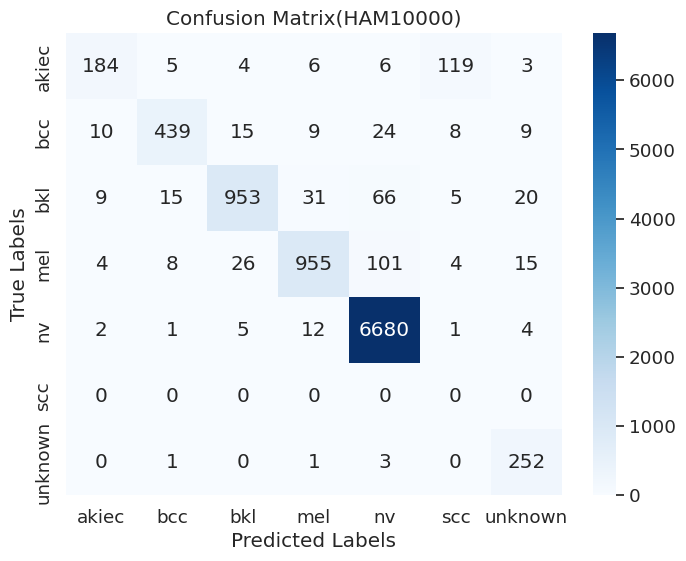


Multiclass Accuracy(HAM10000): 0.9448826759860209
HAM10000 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.880383  0.562691  0.686567    327.000000
bcc            0.936034  0.854086  0.893184    514.000000
bkl            0.950150  0.867152  0.906755   1099.000000
mel            0.941815  0.858041  0.897978   1113.000000
nv             0.970930  0.996271  0.983438   6705.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.831683  0.980545  0.900000    257.000000
accuracy       0.944883  0.944883  0.944883      0.944883
macro avg      0.787285  0.731255  0.752560  10015.000000
weighted avg   0.957093  0.944883  0.949059  10015.000000

Multiclass ROC AUC Score(HAM10000): 0.9195969225883097


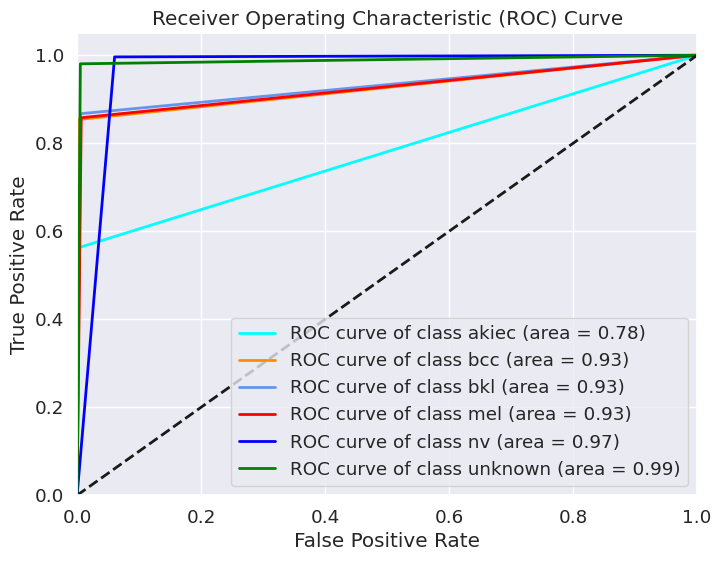

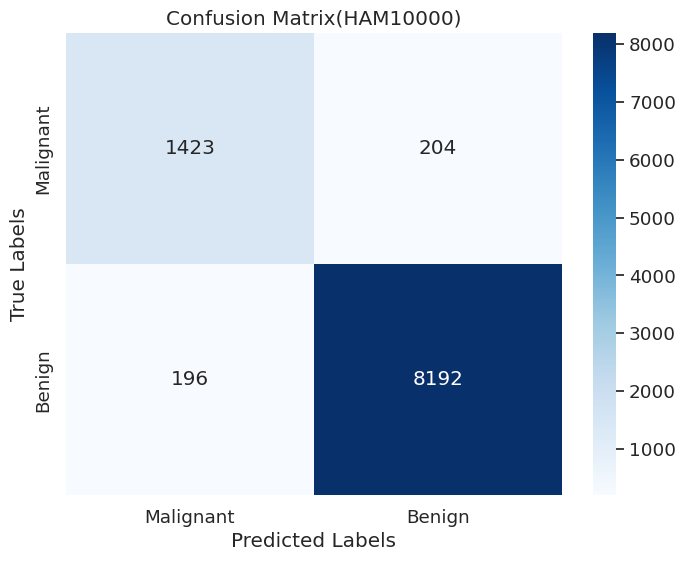


Binary Class Accuracy(HAM10000): 0.9600599101347979
HAM10000 Binary class Classification Report:
              precision    recall  f1-score      support
Malignant      0.878938  0.874616  0.876771   1627.00000
Benign         0.975703  0.976633  0.976168   8388.00000
accuracy       0.960060  0.960060  0.960060      0.96006
macro avg      0.927320  0.925625  0.926470  10015.00000
weighted avg   0.959983  0.960060  0.960020  10015.00000

Binary Class ROC AUC Score(HAM10000): 0.9256245715262151


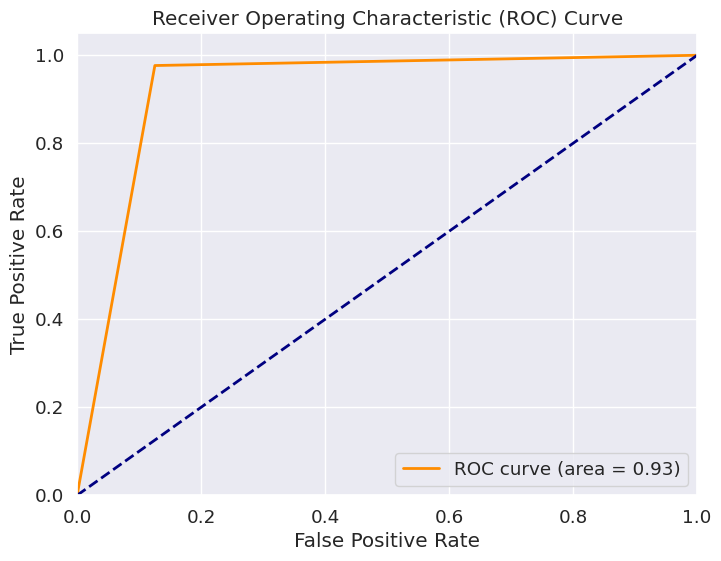

In [22]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/HAM10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    27124
nv          5193
mel          584
bkl          225
Name: count, dtype: int64
label
6    27124
4     5193
3      584
2      225
Name: count, dtype: int64
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step


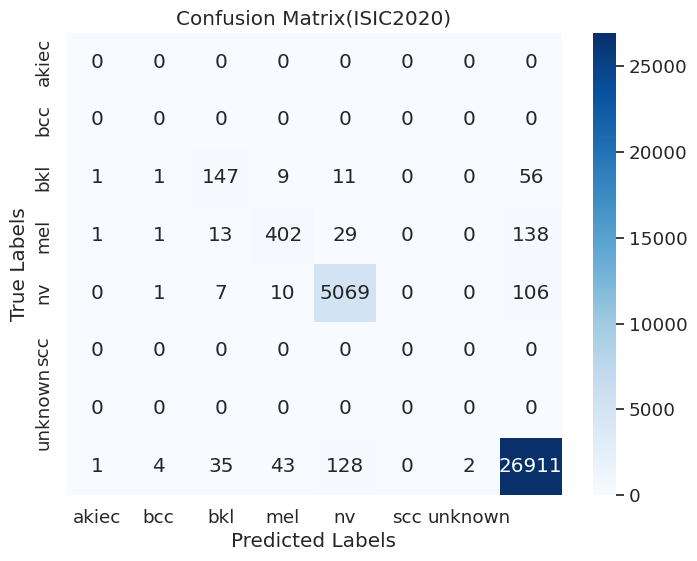


Multiclass Accuracy(ISIC2020): 0.9819779025538852
ISIC2020 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.000000  0.000000  0.000000      0.000000
bcc            0.000000  0.000000  0.000000      0.000000
bkl            0.727723  0.653333  0.688525    225.000000
mel            0.866379  0.688356  0.767176    584.000000
nv             0.967921  0.976122  0.972004   5193.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.988975  0.992147  0.990559  27124.000000
accuracy       0.981978  0.981978  0.981978      0.981978
macro avg      0.507285  0.472851  0.488323  33126.000000
weighted avg   0.981739  0.981978  0.981660  33126.000000

Multiclass ROC AUC Score(ISIC2020): 0.906297966699801


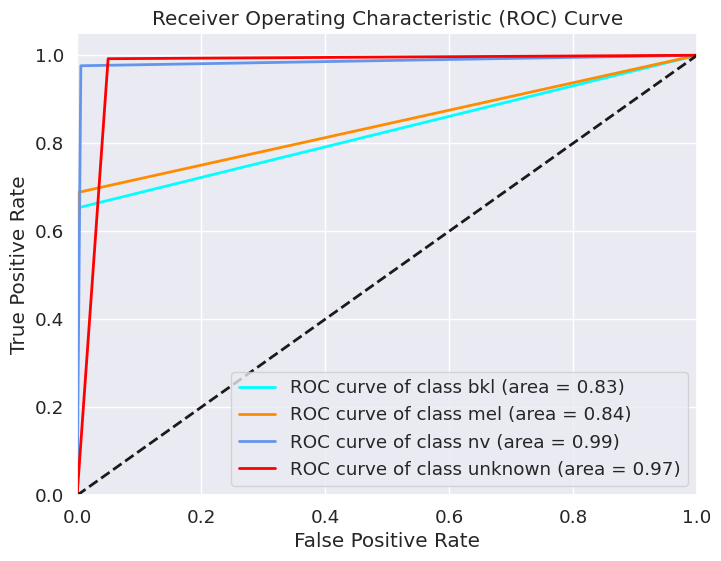

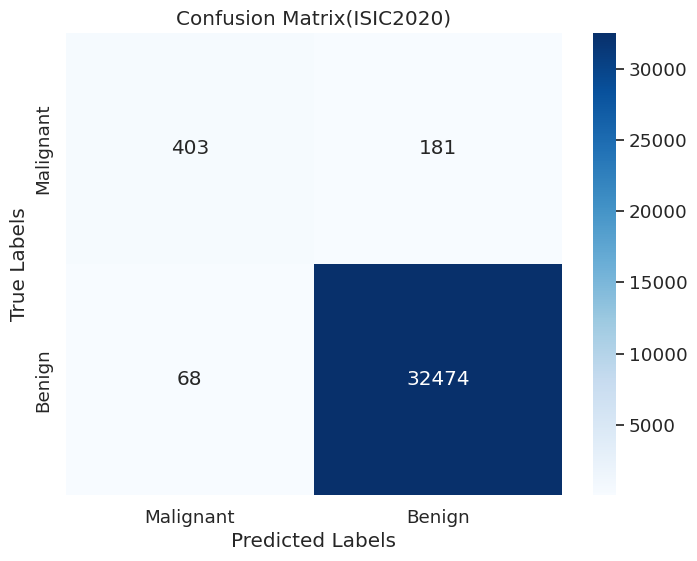


Binary Class Accuracy(ISIC2020): 0.9924832457888064
ISIC2020 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.855626  0.690068  0.763981    584.000000
Benign         0.994457  0.997910  0.996181  32542.000000
accuracy       0.992483  0.992483  0.992483      0.992483
macro avg      0.925042  0.843989  0.880081  33126.000000
weighted avg   0.992010  0.992483  0.992087  33126.000000

Binary Class ROC AUC Score(ISIC2020): 0.8439894429369674


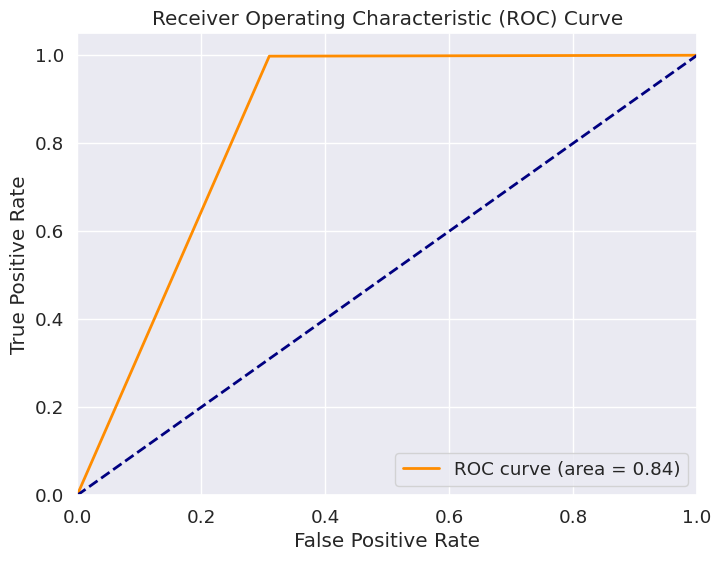

In [23]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         12875
mel         4522
bcc         3323
bkl         2624
akiec        867
scc          628
unknown      492
Name: count, dtype: int64
label
4    12875
3     4522
1     3323
2     2624
0      867
5      628
6      492
Name: count, dtype: int64
792/792 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step


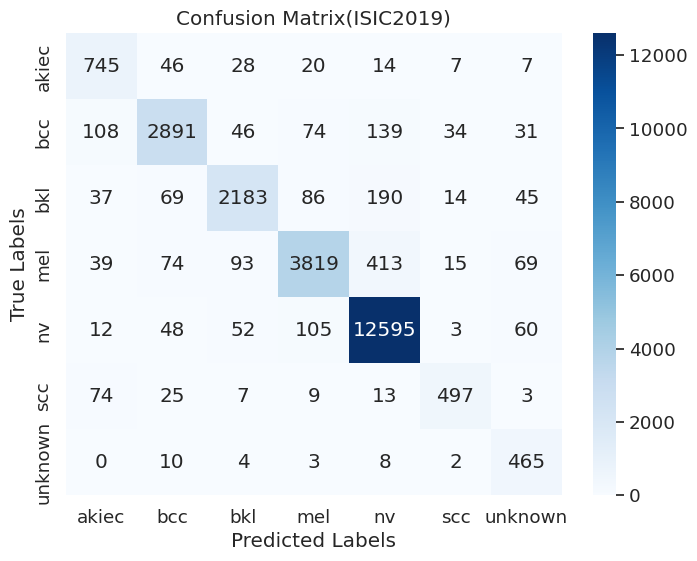


Multiclass Accuracy(ISIC2019): 0.9156764438829892
ISIC2019 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.733990  0.859285  0.791711    867.000000
bcc            0.914006  0.869997  0.891459   3323.000000
bkl            0.904683  0.831936  0.866786   2624.000000
mel            0.927843  0.844538  0.884232   4522.000000
nv             0.941894  0.978252  0.959729  12875.000000
scc            0.868881  0.791401  0.828333    628.000000
unknown        0.683824  0.945122  0.793515    492.000000
accuracy       0.915676  0.915676  0.915676      0.915676
macro avg      0.853589  0.874362  0.859395  25331.000000
weighted avg   0.917934  0.915676  0.915431  25331.000000

Multiclass ROC AUC Score(ISIC2019): 0.9284758902559089


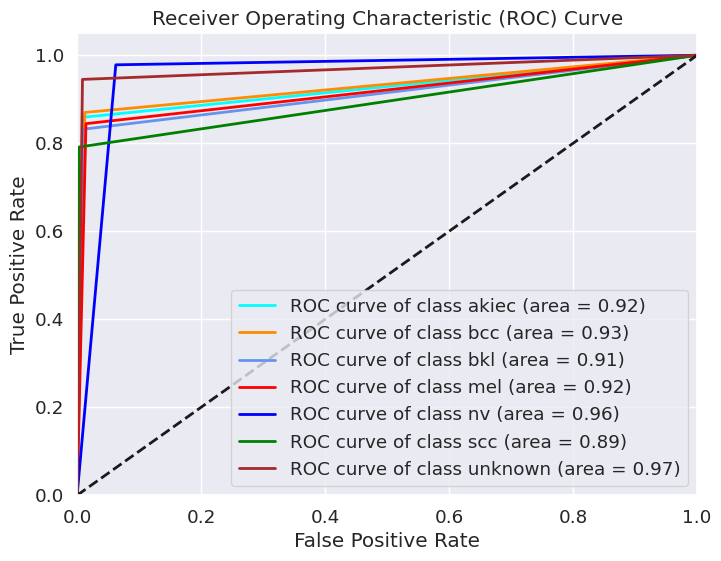

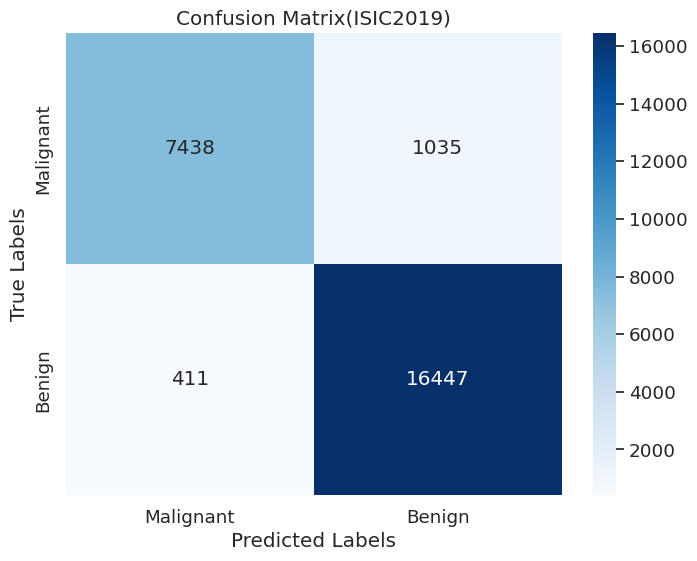


Binary Class Accuracy(ISIC2019): 0.9429157948758439
ISIC2019 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.947637  0.877847  0.911408   8473.000000
Benign         0.940796  0.975620  0.957892  16858.000000
accuracy       0.942916  0.942916  0.942916      0.942916
macro avg      0.944216  0.926734  0.934650  25331.000000
weighted avg   0.943084  0.942916  0.942343  25331.000000

Binary Class ROC AUC Score(ISIC2019): 0.9267335816643649


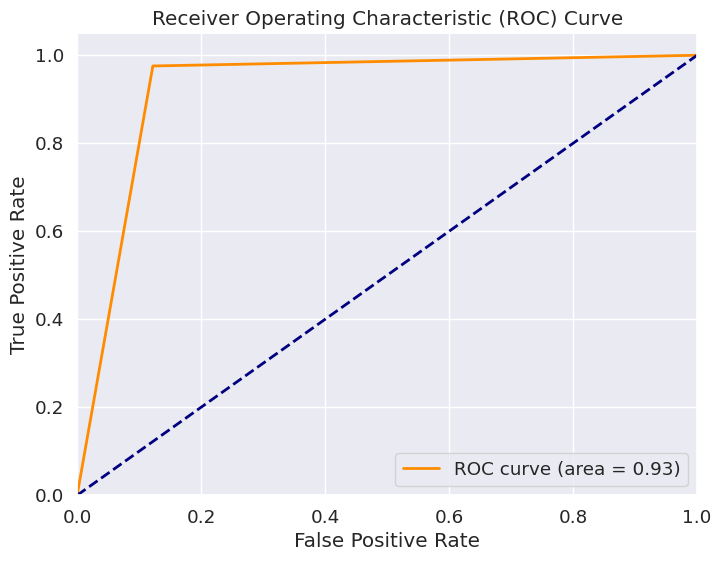

In [24]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

2140/2140 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step


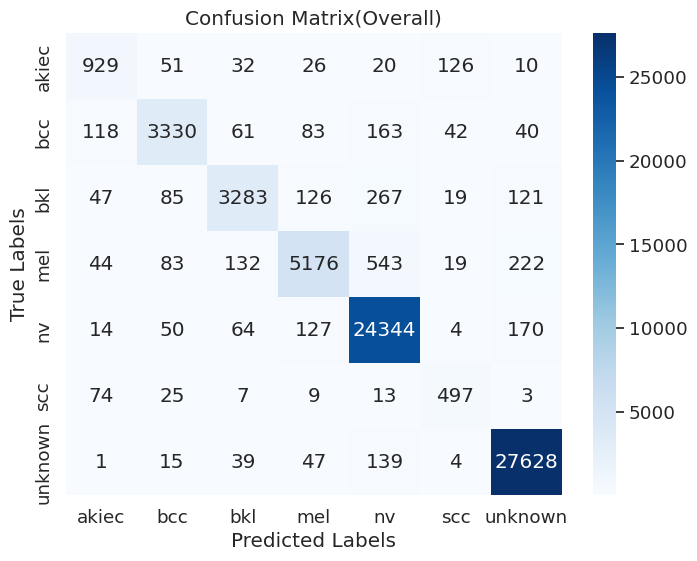


Multiclass Accuracy(Overall): 0.9520241850683491
Overall Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.757131  0.778057  0.767451   1194.000000
bcc            0.915087  0.867866  0.890851   3837.000000
bkl            0.907407  0.831560  0.867830   3948.000000
mel            0.925277  0.832288  0.876323   6219.000000
nv             0.955079  0.982683  0.968684  24773.000000
scc            0.699015  0.791401  0.742345    628.000000
unknown        0.979925  0.991210  0.985535  27873.000000
accuracy       0.952024  0.952024  0.952024      0.952024
macro avg      0.876989  0.867866  0.871288  68472.000000
weighted avg   0.951696  0.952024  0.951393  68472.000000

Multiclass ROC AUC Score(Overall): 0.9293322210636507


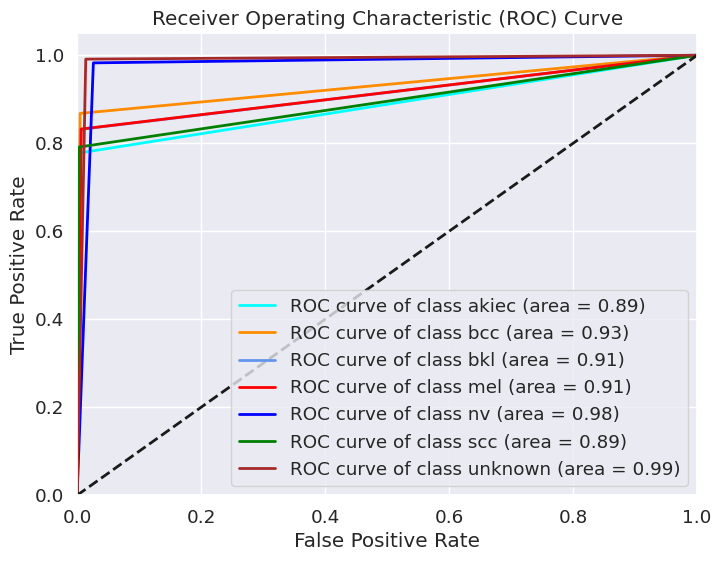

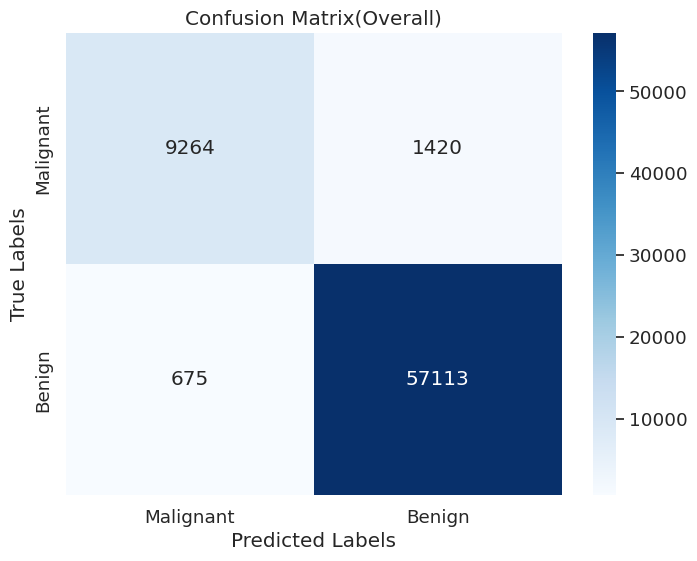


Binary Class Accuracy(Overall): 0.969403551816801
Overall Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.932086  0.867091  0.898414  10684.000000
Benign         0.975740  0.988319  0.981989  57788.000000
accuracy       0.969404  0.969404  0.969404      0.969404
macro avg      0.953913  0.927705  0.940202  68472.000000
weighted avg   0.968929  0.969404  0.968949  68472.000000

Binary Class ROC AUC Score(Overall): 0.9277051757133324


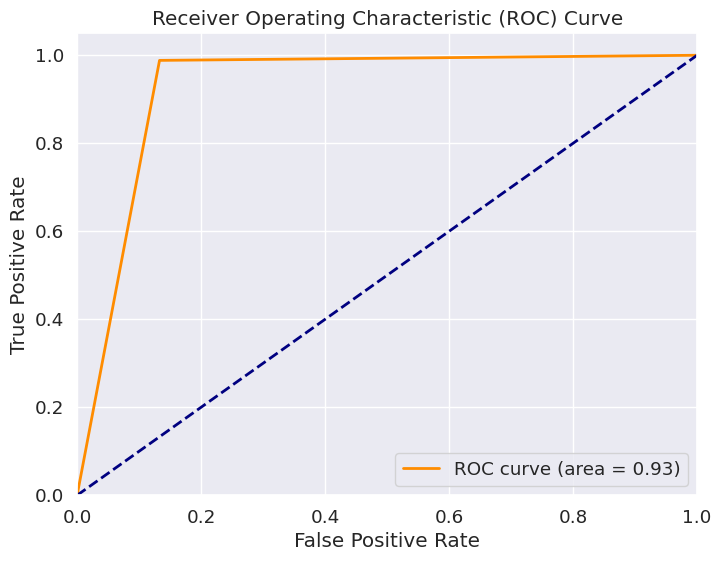

In [25]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         1340
mel         222
bkl         221
bcc         103
akiec        65
unknown      52
Name: count, dtype: int64
label
4    1340
3     222
2     221
1     103
0      65
6      52
Name: count, dtype: int64
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


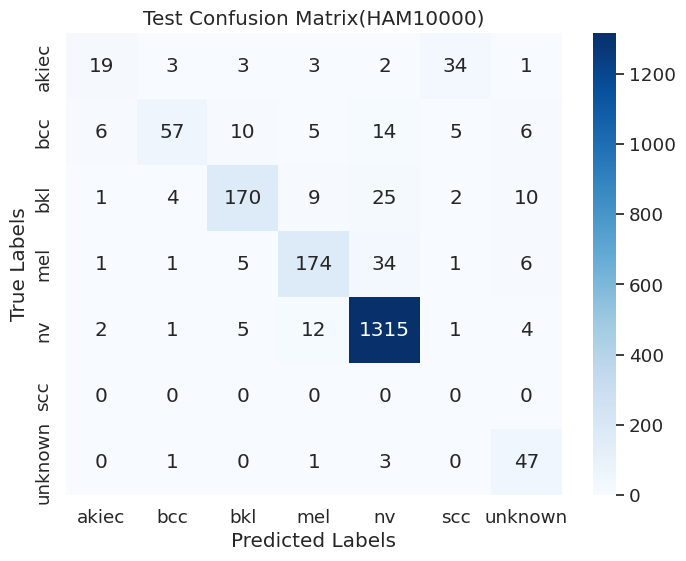


Multiclass Testing Accuracy(HAM10000): 0.8896655017473789
HAM10000 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.655172  0.292308  0.404255    65.000000
bcc            0.850746  0.553398  0.670588   103.000000
bkl            0.880829  0.769231  0.821256   221.000000
mel            0.852941  0.783784  0.816901   222.000000
nv             0.944006  0.981343  0.962312  1340.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.635135  0.903846  0.746032    52.000000
accuracy       0.889666  0.889666  0.889666     0.889666
macro avg      0.688404  0.611987  0.631621  2003.000000
weighted avg   0.904755  0.889666  0.891907  2003.000000

Multiclass Testing ROC AUC Score(HAM10000): 0.8426874327525855


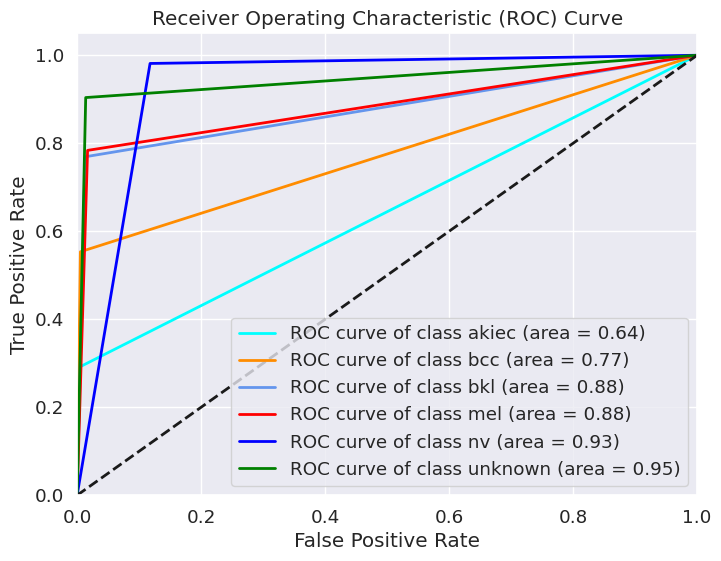

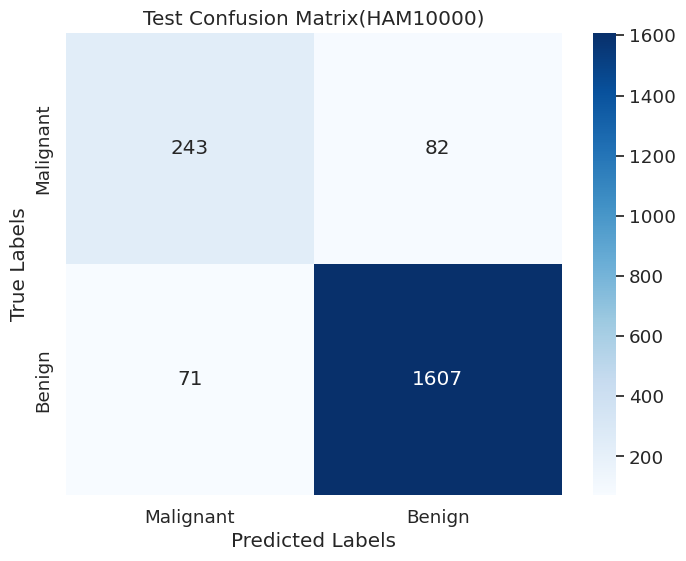


Binary Class Testing Accuracy(HAM10000): 0.9236145781328008
HAM10000 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.773885  0.747692  0.760563   325.000000
Benign         0.951451  0.957688  0.954559  1678.000000
accuracy       0.923615  0.923615  0.923615     0.923615
macro avg      0.862668  0.852690  0.857561  2003.000000
weighted avg   0.922639  0.923615  0.923082  2003.000000

Binary Class ROC AUC Score(HAM10000): 0.8526900155863207


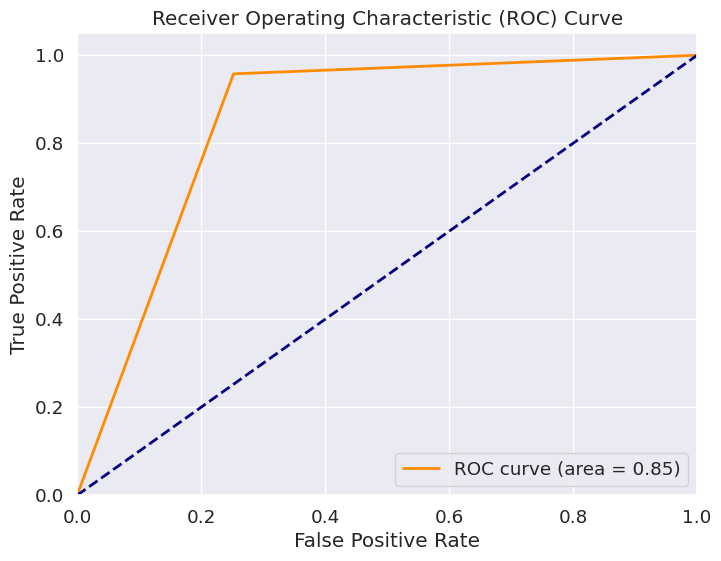

In [26]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/ham10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    5447
nv         1030
mel         105
bkl          44
Name: count, dtype: int64
label
6    5447
4    1030
3     105
2      44
Name: count, dtype: int64
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step


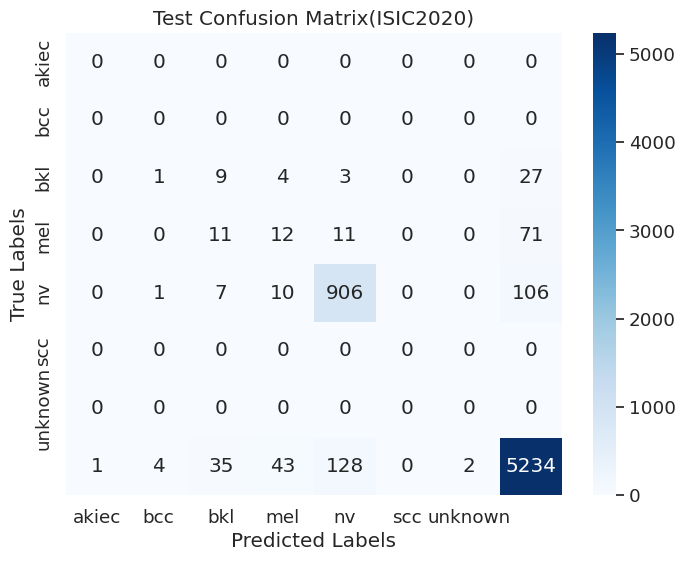


Multiclass Testing Accuracy(ISIC2020): 0.9298219136734078
ISIC2020 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.000000  0.000000  0.000000     0.000000
bcc            0.000000  0.000000  0.000000     0.000000
bkl            0.145161  0.204545  0.169811    44.000000
mel            0.173913  0.114286  0.137931   105.000000
nv             0.864504  0.879612  0.871992  1030.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.962486  0.960896  0.961690  5447.000000
accuracy       0.929822  0.929822  0.929822     0.929822
macro avg      0.306581  0.308477  0.305918  6626.000000
weighted avg   0.929331  0.929822  0.929435  6626.000000

Multiclass Testing ROC AUC Score(ISIC2020): 0.7430177766317744


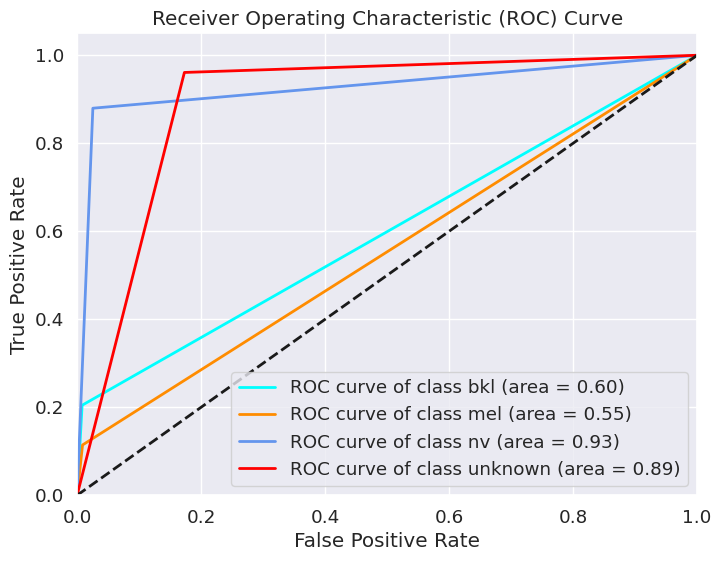

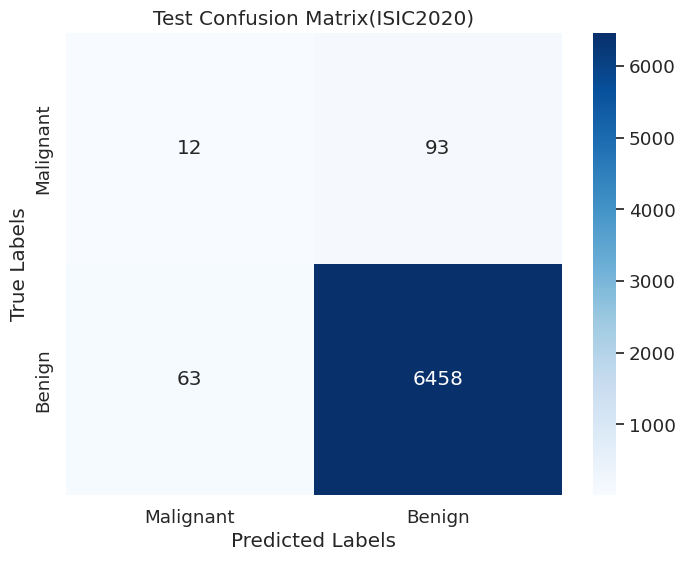


Binary Class Testing Accuracy(ISIC2020): 0.9764563839420465
ISIC2020 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.160000  0.114286  0.133333   105.000000
Benign         0.985804  0.990339  0.988066  6521.000000
accuracy       0.976456  0.976456  0.976456     0.976456
macro avg      0.572902  0.552312  0.560700  6626.000000
weighted avg   0.972717  0.976456  0.974521  6626.000000

Binary Class ROC AUC Score(ISIC2020): 0.5523123096808115


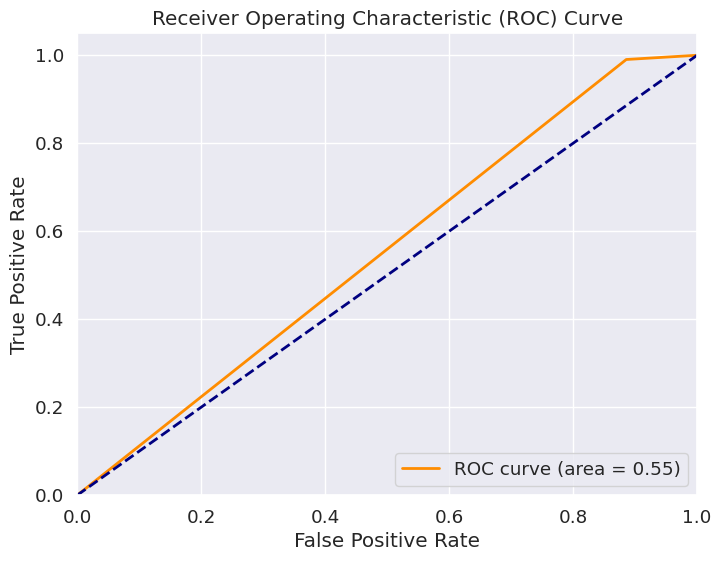

In [27]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         2622
mel         857
bcc         695
bkl         508
akiec       164
scc         128
unknown      93
Name: count, dtype: int64
label
4    2622
3     857
1     695
2     508
0     164
5     128
6      93
Name: count, dtype: int64
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step


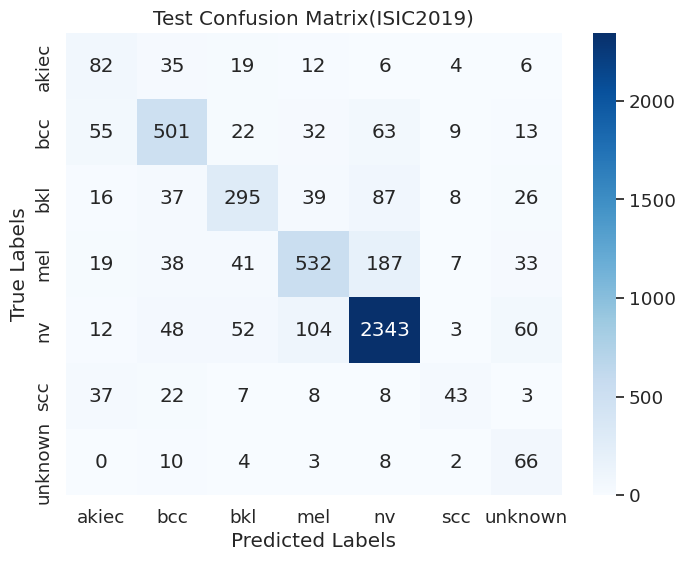


Multiclass Testing Accuracy(ISIC2019): 0.7621866982435366
ISIC2019 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.371041  0.500000  0.425974   164.000000
bcc            0.725036  0.720863  0.722944   695.000000
bkl            0.670455  0.580709  0.622363   508.000000
mel            0.728767  0.620770  0.670447   857.000000
nv             0.867135  0.893593  0.880165  2622.000000
scc            0.565789  0.335938  0.421569   128.000000
unknown        0.318841  0.709677  0.440000    93.000000
accuracy       0.762187  0.762187  0.762187     0.762187
macro avg      0.606723  0.623079  0.597637  5067.000000
weighted avg   0.770791  0.762187  0.762920  5067.000000

Multiclass Testing ROC AUC Score(ISIC2019): 0.7877890034589982


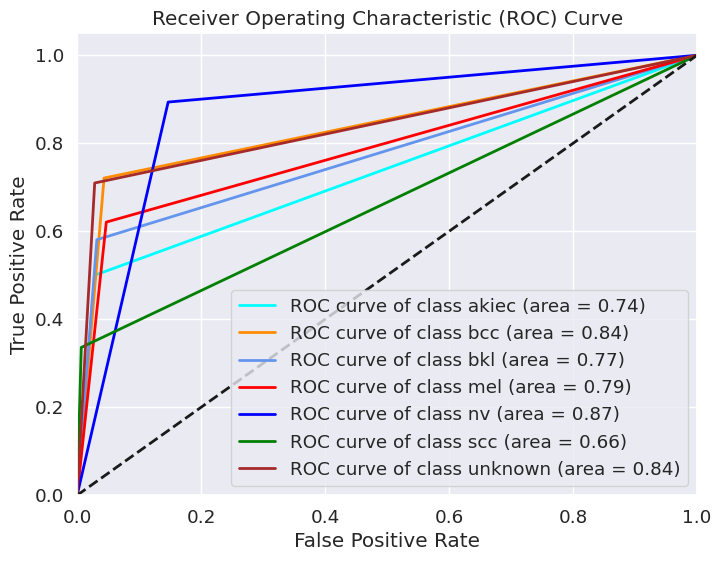

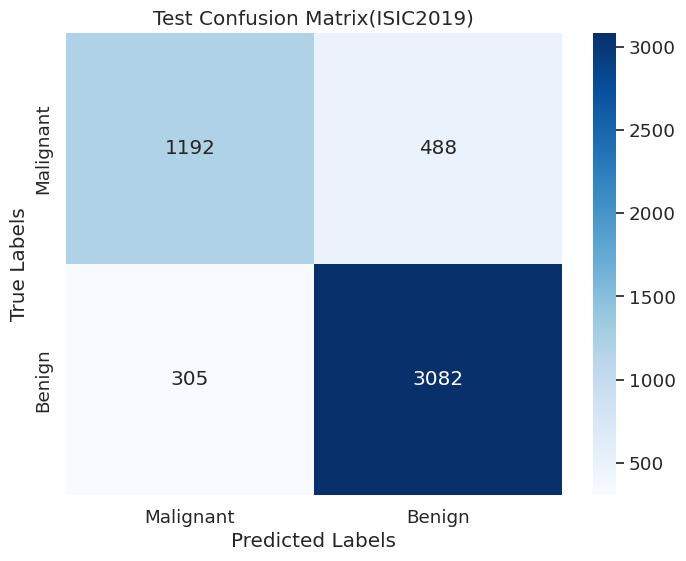


Binary Class Testing Accuracy(ISIC2019): 0.8434971383461615
ISIC2019 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.796259  0.709524  0.750393  1680.000000
Benign         0.863305  0.909950  0.886014  3387.000000
accuracy       0.843497  0.843497  0.843497     0.843497
macro avg      0.829782  0.809737  0.818204  5067.000000
weighted avg   0.841076  0.843497  0.841048  5067.000000

Binary Class ROC AUC Score(ISIC2019): 0.8097368088067821


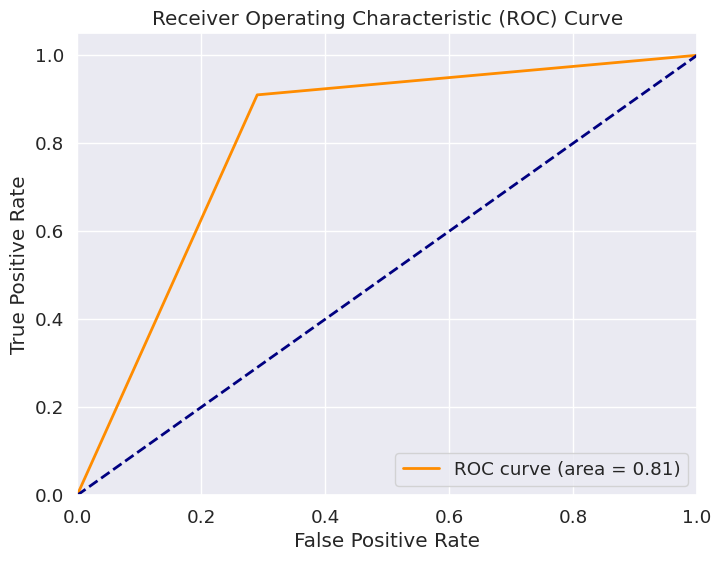

In [28]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step


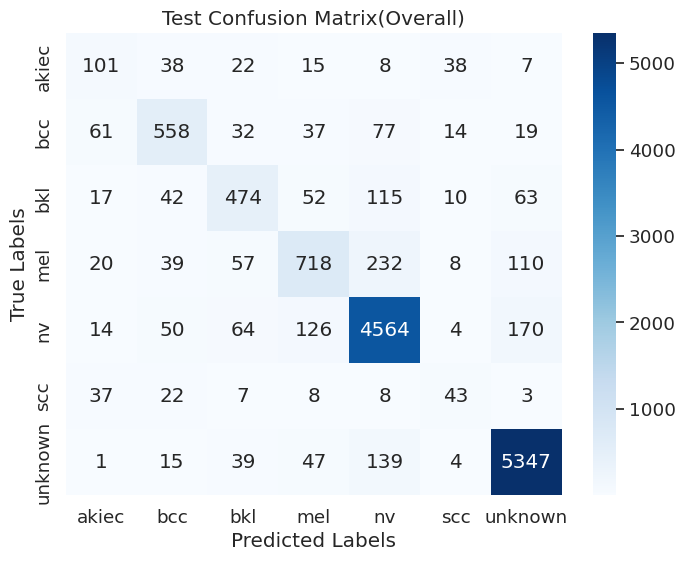


Multiclass Testing Accuracy(Overall): 0.8619304906542056
Overall Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.402390  0.441048  0.420833    229.00000
bcc            0.730366  0.699248  0.714469    798.00000
bkl            0.682014  0.613195  0.645777    773.00000
mel            0.715852  0.606419  0.656607   1184.00000
nv             0.887420  0.914263  0.900641   4992.00000
scc            0.355372  0.335938  0.345382    128.00000
unknown        0.934954  0.956187  0.945451   5592.00000
accuracy       0.861930  0.861930  0.861930      0.86193
macro avg      0.672624  0.652328  0.661309  13696.00000
weighted avg   0.858170  0.861930  0.859397  13696.00000

Multiclass Testing ROC AUC Score(Overall): 0.8129382641497135


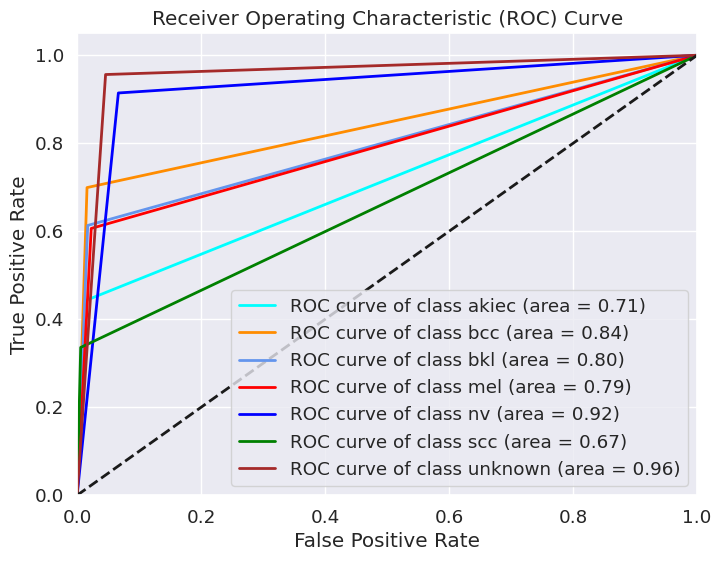

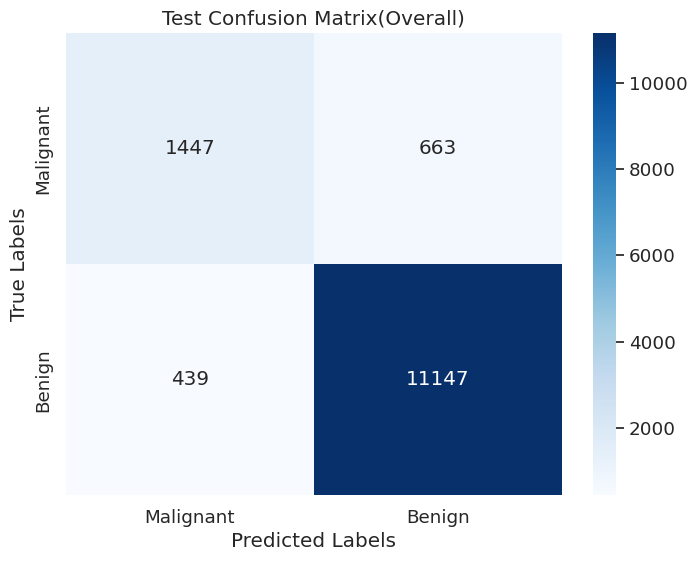


Binary Class Testing Accuracy(Overall): 0.9195385514018691
Overall Binary class Testing Classification Report:
              precision    recall  f1-score       support
Malignant      0.767232  0.685782  0.724224   2110.000000
Benign         0.943861  0.962109  0.952898  11586.000000
accuracy       0.919539  0.919539  0.919539      0.919539
macro avg      0.855547  0.823946  0.838561  13696.000000
weighted avg   0.916650  0.919539  0.917669  13696.000000

Binary Class ROC AUC Score(Overall): 0.8239457164759232


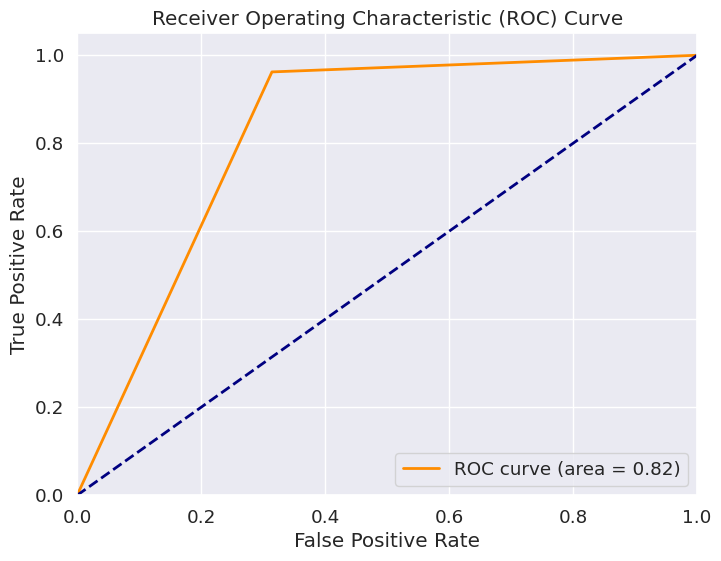

In [29]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()